In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False


import numpy as np
import matplotlib 
%matplotlib notebook

import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.autolayout': True})
from scipy.integrate import trapz

import sys, glob
sys.path.append('../../')

from ase import Atoms
import MDAnalysis as mda
import nglview as nv

from cmm.xray.sgr import Damping
from cmm.xray.sgr2 import RDF, SGr as SGr2, RDFSet

def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors


## Testing the sgr2.py on the simple Pt-Pt system
Checking it gives the same as debye plus the old code

<IPython.core.display.Javascript object>


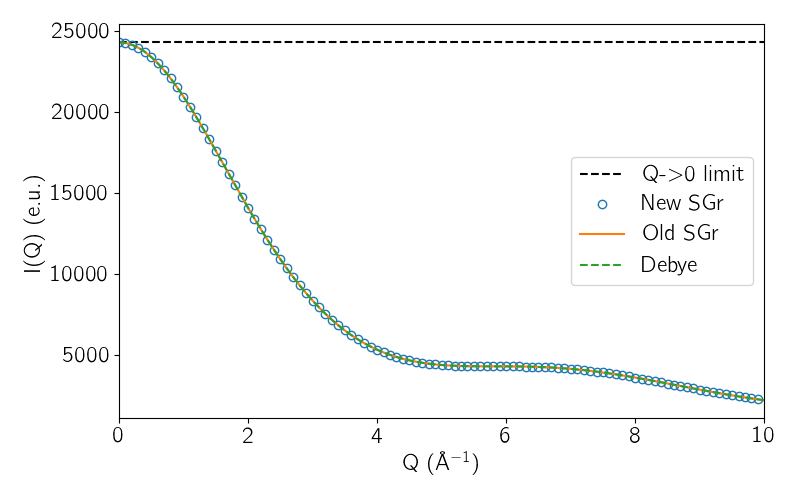

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from cmm.xray.sgr import SGr as SGr_old
from cmm.xray.sgr2 import SGr as SGr2
from cmm.xray.debye import Debye
from ase.io import read 

nel = (2*78)**2

atoms = read('../../data/test/test.xyz')
deb = Debye()
s_deb = deb.debye(atoms)

stoich = {'Pt_u':2}
Vtest = 10**3
sgr_old_test = SGr_old(Vtest, damp=None, delta=False, verbose=False, qvec=deb.qvec)
sgr_old_test.load_rdfs_fromdir('../../data/test/')
s_sgr_old_test = sgr_old_test.calculate(sgr_old_test.rdfs, stoich)


dat = np.genfromtxt('../../data/test/gPt_u-Pt_u.dat')
rdf_test = RDF(dat[:, 0], dat[:, 1], 'Pt', 'Pt', 'solute', 'solute', 2, 2)
sgr_new_test = SGr2(Vtest, qvec=deb.qvec)
s_sgr_new_test = sgr_new_test.scoh(rdf_test)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(deb.qvec, np.ones_like(s_deb) * nel, 'k--', label='Q-$>$0 limit')
ax.plot(deb.qvec[::10], s_sgr_new_test[::10], 'o', mfc='None', label='New SGr')
ax.plot(deb.qvec, s_sgr_old_test['s_u'], label='Old SGr')
ax.plot(deb.qvec, s_deb, '--', label='Debye')
ax.set_xlim([0, 10])
ax.set_ylabel('I(Q) (e.u.)')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.legend(loc='best');

### Testing sgr2.py gives the same (uncorrected) water scattering signal

<IPython.core.display.Javascript object>


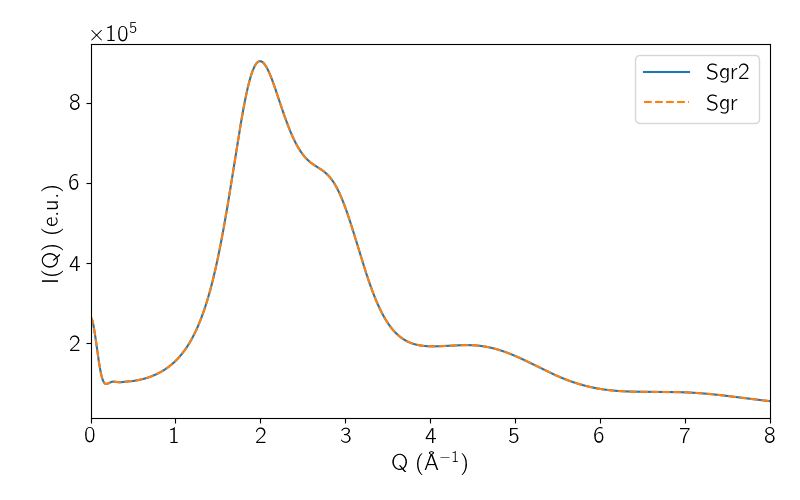

In [3]:
from cmm.xray.sgr import SGr as SGr_old

import warnings  # MDAnalysis doesn't like the charge sites of tip4p in the prmtop.
warnings.filterwarnings("ignore")


rdf_files = sorted(glob.glob('../../data/md/water/waterbox_16384_amber/*dat'))
# Load universe to get stoichometry.
u = mda.Universe('../../data/md/water/waterbox_16384_amber.prmtop') 

# Unfortunately mda cannot get the box size from the prmtop, even though it is there
with open('../../data/md/water/waterbox_16384_amber.prmtop', 'r') as f:
    lines = f.readlines()
for l, line in enumerate(lines):
    if 'FLAG BOX_DIMENSIONS' in line:
        box = lines[l + 2]
box = [float(x) for x in box.split()[1:] ]
V = np.prod(box)
where1 = where2 = 'solvent'  # neat solvent RDFs. 


### Create the RDFSet 
rdfs = RDFSet()  
for f, file in enumerate(rdf_files):
    data = np.genfromtxt(file)
    r = data[:, 0]
    g = data[:, 1]
    
    # find elements from file name. This is very specific to this exact naming scheme... 
    el1 = file.split('/')[-1][1]
    el2 = file.split('/')[-1][-7]
    Ni = len([atom for atom in u.atoms if el1 in atom.name])
    Nj = len([atom for atom in u.atoms if el2 in atom.name])
    kd = int(el1 == el2)
    
    # make RDF object:
    rdf = RDF(r, g, el1, el2, where1, where2, n1=Ni, n2=Nj)
    rdf.damp = Damping('simple', L=r[-1])
    rdfs[(rdf.name1, rdf.region1, rdf.name2, rdf.region2)] = rdf
    

### Calculate Scattering
qvec = np.arange(0, 8, 0.01)
sgr = SGr2(V, qvec=qvec)    
   
s_tot_new = np.zeros(len(qvec))
for i, (key, rdf) in enumerate(rdfs.items()):
    s_tot_new += sgr.scoh(rdf)

    
## Also calculate the old way:    
stoich = {'O_v':16383, 'H_v': 16383 * 2}
sgr_old = SGr_old(V, damp=Damping('simple', L=r[-1]), 
                delta=False, verbose=False, qvec=qvec)
sgr_old.load_rdfs_fromdir('../../data/md/water/waterbox_16384_amber/')
s_tot_old = sgr_old.calculate(sgr_old.rdfs, stoich)

## Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(qvec, s_tot_new, label='Sgr2')
ax.plot(qvec, s_tot_old['s_v_damp'], '--', label='Sgr')
ax.set_xlim([0, 8])
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.tight_layout()
ax.set_ylabel('I(Q) (e.u.)')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.legend(loc='best');

    

Both implementations give the same water signal. Let us move on to treating the low-q.

## Using the new `Sgr` to estimate best low-q treatment

Using the biggest of the neat water boxes from `data/md/water/`

Define g-correction methods

\begin{align} 
g_{ij}^\mathrm{VC}(r) = g_{ij}^N(r) \frac{N_j(V - V_i)}{(N_j - \delta_{ij}) V},
\end{align}

and

\begin{align} 
    g^\mathrm{PE}_{ij}(r) = g^N_{ij}(r) \left [ 
                    1 + \frac{1 - g^{N,0}}{2}  \left( 1 + \tanh \left( \frac{r - \kappa_{ij}}{\alpha_{ij}} \right)   \right)
                  \right ].
\end{align}
The difference between the correct asymptotic limit and the sampled, $1 - g^{N,0}$ is used in a smooth switching function, where $\alpha_{ij}$ controls the smoothness of the switch from $g^{N,0}$ to 1.
$\kappa_{ij}$ represents an effective diameter with which particle of type $i$ and $j$ displace each other, as it is taken in the original paper to be twice the distance at which $g_{ij}(r)$ starts to be different from zero.

In [20]:
def vc(g, N, Ri, V, kd=1):
    Vnew = V - (4/3) * Ri**3 *np.pi
    fac = (Vnew/V) * (N / (N - kd))  
    return g * fac

def perera(g, r, kappa, alpha, g0_avg):
    fac = 1 + ((1 - g0_avg)/2) * (1 + np.tanh((r - kappa) / alpha) )
    return g * fac

Find the data:

In [21]:
rdf_files = sorted(glob.glob('../../data/md/water/waterbox_16384_amber/*dat'))
rdf_files

['../../data/md/water/waterbox_16384_amber/gH_v-H_v.dat',
 '../../data/md/water/waterbox_16384_amber/gH_v-O_v.dat',
 '../../data/md/water/waterbox_16384_amber/gO_v-H_v.dat',
 '../../data/md/water/waterbox_16384_amber/gO_v-O_v.dat']

Set/tune the necessary correction parameters: 

In [22]:
Rs = [1.88, -0.78, -0.78, 2.375] 

Load data, calculate S(0)

In [23]:
rdf_files = sorted(glob.glob('../../data/md/water/waterbox_16384_amber/*dat'))
 
# Load universe to get stoichometry.
u = mda.Universe('../../data/md/water/waterbox_16384_amber.prmtop') 

# Unfortunately mda cannot get the box size from the prmtop, even though it is there
with open('../../data/md/water/waterbox_16384_amber.prmtop', 'r') as f:
    lines = f.readlines()
for l, line in enumerate(lines):
    if 'FLAG BOX_DIMENSIONS' in line:
        box = lines[l + 2]
box = [float(x) for x in box.split()[1:] ]
V = np.prod(box)

where1 = where2 = 'solvent'  # neat solvent RDFs. 

set_vc = RDFSet()  # Volume Corrected
set_pe = RDFSet()  # Perera Corrected
set_uc = RDFSet()  # Uncorrected

for f, file in enumerate(rdf_files):
    data = np.genfromtxt(file)
    r = data[:, 0]
    g = data[:, 1]
    
    # find elements from file name. This is very specific to this exact naming scheme... 
    el1 = file.split('/')[-1][1]
    el2 = file.split('/')[-1][-7]
    Ni = len([atom for atom in u.atoms if el1 in atom.name])
    Nj = len([atom for atom in u.atoms if el2 in atom.name])
    kd = int(el1 == el2)
    
    # make RDF object, corrected with volume correction, add to set:
    rdf = RDF(r, vc(g, Nj, Rs[f], V, kd), el1, el2, where1, where2, n1=Ni, n2=Nj)
    set_vc[(rdf.name1, rdf.region1, rdf.name2, rdf.region2)] = rdf
    
    # also Perera
    g0_avg = np.mean(g[r > 20])
    rdf = RDF(r, perera(g, r, 2 * Rs[f], 3 * Rs[f], g0_avg), el1, el2, where1, where2, n1=Ni, n2=Nj)
    set_pe[(rdf.name1, rdf.region1, rdf.name2, rdf.region2)] = rdf
    
    # and uncorrected
    rdf = RDF(r, g, el1, el2, where1, where2, n1=Ni, n2=Nj)
    set_uc[(rdf.name1, rdf.region1, rdf.name2, rdf.region2)] = rdf


Loop over increasing trunctation length and see how the S(0) asymptote evolves

<IPython.core.display.Javascript object>


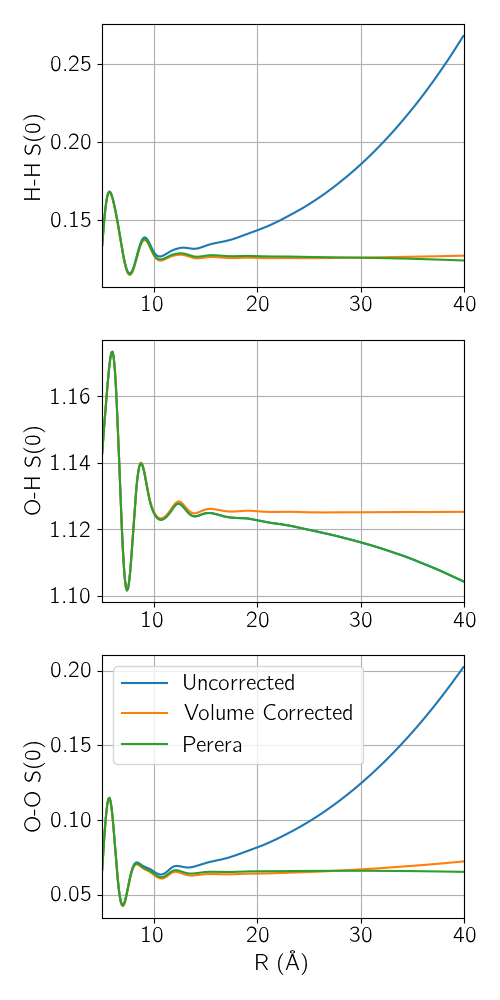

In [30]:
from copy import deepcopy

rmaxs = np.arange(5, 40, 0.1)  # all the way down to 5 is mostly for visualization purposes. Way too low. 

sgr2 = SGr2(V, qvec=np.arange(0, 0.1, 0.01)) # we in principle only need Q=0
s_vc = np.zeros((len(sgr2.qvec), len(rmaxs)))
s_pe = np.zeros((len(sgr2.qvec), len(rmaxs)))
s_uc = np.zeros((len(sgr2.qvec), len(rmaxs)))


fig, axes = plt.subplots(3, 1, figsize=(5, 10))
ct = 0
for i, (key, org_rdf) in enumerate(set_vc.items()):
    if key == ('H', 'solvent', 'O', 'solvent'):  # skip the double. OH = HO
        continue
    for j, r_max in enumerate(rmaxs):
        damp = Damping('simple', L=r_max)
        
        rdf_vc = deepcopy(org_rdf)
        rdf_pe = deepcopy(set_pe[key])
        rdf_uc = deepcopy(set_uc[key])

        rdf_vc.damp = damp
        rdf_vc.r_max = r_max

        rdf_pe.damp = damp
        rdf_pe.r_max = r_max
        
        rdf_uc.damp = damp
        rdf_uc.r_max = r_max
        
        s_vc[:, j] = sgr2.structure_factor(rdf_vc)
        s_pe[:, j] = sgr2.structure_factor(rdf_pe)
        s_uc[:, j] = sgr2.structure_factor(rdf_uc)
        
    ax = axes[ct]
    ax.plot(rmaxs, s_uc[i, :], label='Uncorrected')
    ax.plot(rmaxs, s_vc[i, :], label='Volume Corrected')
    ax.plot(rmaxs, s_pe[i, :], label='Perera')
    ax.set_ylabel(f'{key[0]}-{key[2]} S(0)')
    ax.grid()
    ax.set_xlim([5, 40])
    ct += 1
    
ax.set_xlabel('R (Å)') 
ax.legend(loc='best')

Adjust `Rs` - within reason - to get convergent behaviour.

### Fit `Rs` using `DVOpt`:

In [32]:
from cmm.xray.sgr2 import DVOpt
R0s = [1.88, 1, 1, 2] 
R0s_pe = [1.88, 1, 1, 2] 

<IPython.core.display.Javascript object>


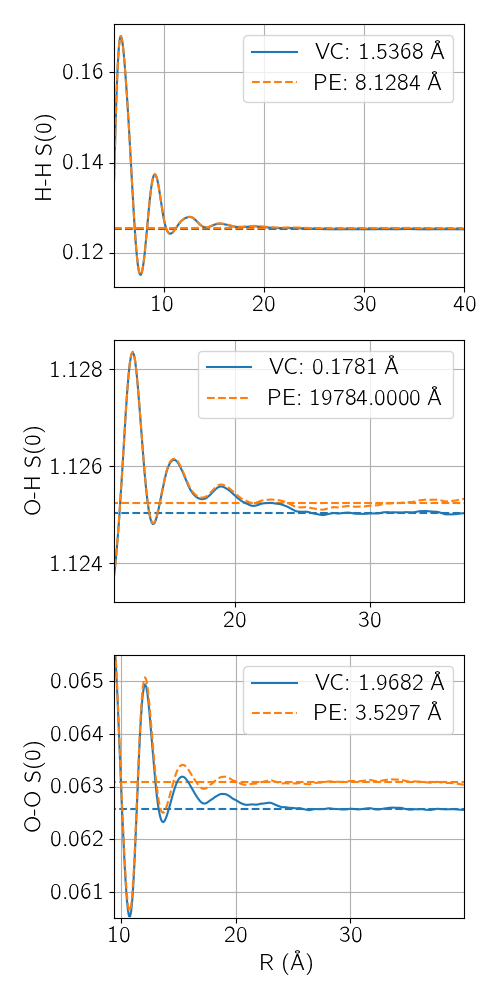

(1.1231840156, 1.128617398521579)

In [33]:
rmaxs = np.arange(5, 40, 0.1)  # all the way down to 5 is mostly for visualization purposes. Way too low. 

sgr2 = SGr2(V, qvec=np.arange(0, 0.1, 0.01)) # we in principle only need Q=0
s_vc = np.zeros((len(sgr2.qvec), len(rmaxs)))
s_pe = np.zeros((len(sgr2.qvec), len(rmaxs)))

fig, axes = plt.subplots(3, 1, figsize=(5, 10))
ct = 0

pe_best_values = []
vc_best_values = []

for i, (key, org_rdf) in enumerate(set_vc.items()):
    if key == ('H', 'solvent', 'O', 'solvent'):  # skip the double. OH = HO
        continue
    org_rdf.volume = V  # add volume to the RDF which is needed for the DVOopt
    
    dvo = DVOpt(org_rdf, fit_strt=25, fit_stop=40, rmaxes=rmaxs)
    dvo.fit(R0s[i])
    
    dvo_pe = DVOpt(deepcopy(org_rdf), fit_strt=25, fit_stop=40, rmaxes=rmaxs, ctype='PE')
    dvo_pe.fit(R0s_pe[i])

    for j, r_max in enumerate(rmaxs):
        damp = Damping('simple', L=r_max)
        
        rdf_vc = deepcopy(org_rdf)
        rdf_pe = deepcopy(set_pe[key])
        
        # VC Correct
        kd = int((rdf_vc.region1 == rdf_vc.region2) and (rdf_vc.name1 == rdf_vc.name2))
        rdf_vc.volume = V
        rdf_vc.g = dvo.volume_correct(dvo.total_opt.x[0])
        rdf_vc.damp = damp
        rdf_vc.r_max = r_max

        # Perera
        rdf_pe.g = dvo_pe.perera_correct(dvo_pe.total_opt.x[0])
        rdf_pe.damp = damp
        rdf_pe.r_max = r_max
        
        s_vc[:, j] = sgr2.structure_factor(rdf_vc)
        s_pe[:, j] = sgr2.structure_factor(rdf_pe)
        
    ax = axes[ct]
    ax.plot(rmaxs, np.zeros_like(rmaxs) + dvo.flat_opt.x[0], 'C0--' )
    ax.plot(rmaxs, np.zeros_like(rmaxs) + dvo_pe.flat_opt.x[0], 'C1--' )
    ax.plot(rmaxs, s_vc[i, :], label=f'VC: {dvo.total_opt.x[0]:6.4f} Å')
    ax.plot(rmaxs, s_pe[i, :], '--', label=f'PE: {dvo_pe.total_opt.x[0]:6.4f} Å')
    ax.set_ylabel(f'{key[0]}-{key[2]} S(0)')
    ax.grid()
    ax.set_xlim([5, 40])
    ax.legend(loc='best')
    ct += 1
    
    pe_best_values.append(dvo_pe.total_opt.x[0])
    vc_best_values.append(dvo.total_opt.x[0])
    if i == 2: # OH - HO:
        pe_best_values.append(dvo_pe.total_opt.x[0])
        vc_best_values.append(dvo.total_opt.x[0])
    
ax.set_xlabel('R (Å)') 
axes[1].set_xlim(11, 37)
axes[1].set_ylim(1.1231840156, 1.128617398521579)

Both corrections struggle with flattening the O-H correlation, which makes sense as it isn't fully converged. 

First, let us also try to fit $R_i$-values simply to minimize $g(r) - 1$ at long $r$-values

In [34]:
from cmm.xray.sgr2 import rdfset_from_dir, DVOpt, SGr
from copy import deepcopy

rdfset =  rdfset_from_dir('../../data/md/water/waterbox_16384_amber/',
                          '../../data/md/water/waterbox_16384_amber.prmtop')

<IPython.core.display.Javascript object>


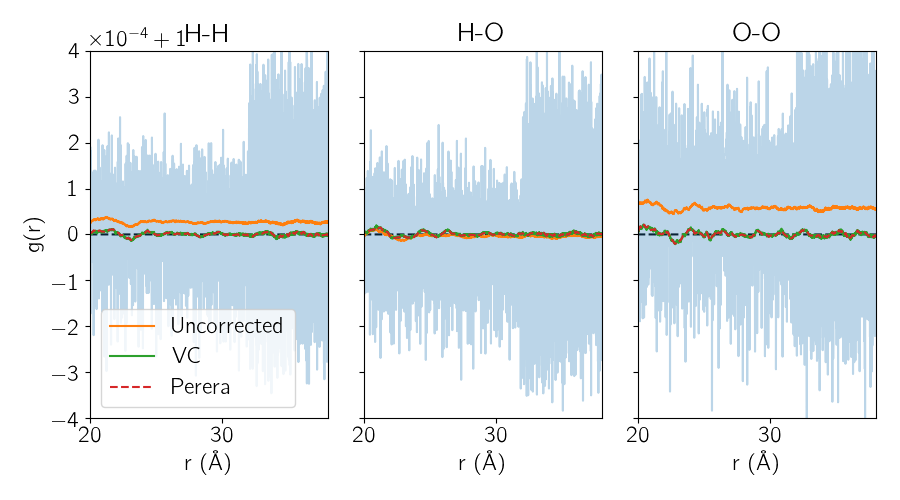

H-solvent-H-solvent, Ri: 1.8844208505991602
Pe:H-solvent-H-solvent, Ri: 3.00625
H-solvent-O-solvent, Ri: -0.8035063526996248
Pe:H-solvent-O-solvent, Ri: 1.0
O-solvent-H-solvent, Ri: -0.8035063526996248
Pe:O-solvent-H-solvent, Ri: 1.0
O-solvent-O-solvent, Ri: 2.402020165293643
Pe:O-solvent-O-solvent, Ri: 2.2034228372775564


In [35]:
from scipy.signal import savgol_filter as sgolay

R0s = [1.85, 1, 1, 2]
rmaxs = np.arange(5, 40, 0.1) # This isn't used in the RDF-fit

vc_rdfset = RDFSet()
pe_rdfset = RDFSet()

fig, axes = plt.subplots(1, 3, figsize=(9, 5))
opts = []
opts_pe = []
ct = 0
dy = 0.0004
for i, (key, org_rdf) in enumerate(rdfset.items()):
    ### VOLUME CORRECT
    dvo = DVOpt(deepcopy(org_rdf), fit_strt=27, fit_stop=40, rmaxes=rmaxs)
    opt = dvo.fit_rdf(R0s[i])
    opts.append(opt.x[0])
    print('-'.join(k for k in key) + f', Ri: {opt.x[0]}')
    # Add VC corrected RDFs to new set
    vc_rdf = deepcopy(org_rdf)
    vc_rdf.g = vc_g = dvo.volume_correct(opt.x[0])
    vc_rdfset[key] = vc_rdf
    
    
    ### PERERA CORRECT
    dvo_pe = DVOpt(deepcopy(org_rdf), fit_strt=27, fit_stop=40, rmaxes=rmaxs, ctype='PE')
    opt_pe = dvo_pe.fit_rdf(R0s[i])
    opts_pe.append(opt_pe.x[0])
    print('Pe:' + '-'.join(k for k in key) + f', Ri: {opt_pe.x[0]}')
    # Add VC corrected RDFs to new set
    pe_rdf = deepcopy(org_rdf)
    pe_rdf.g = pe_g = dvo_pe.perera_correct(opt_pe.x[0])
    pe_rdfset[key] = pe_rdf

    
    if i == 2:
        continue  # dont plot OH also, as its HO
    ax = axes.ravel()[ct]
    ax.plot(org_rdf.r, np.ones_like(org_rdf.r), 'k--')
    ax.plot(org_rdf.r, org_rdf.g, alpha=0.3)
    ax.plot(org_rdf.r, sgolay(org_rdf.g, 301, 3), label='Uncorrected')
    ax.plot(org_rdf.r, sgolay(vc_rdf.g, 201, 3), 'C2', label='VC')
    ax.plot(org_rdf.r[::10], sgolay(pe_rdf.g, 201, 3)[::10], 'C3--', label='Perera')
    
    

    ax.set_xlim([20, 38])
    ax.set_ylim([1-dy, 1 + dy])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel('r (Å)')
    ax.set_title('-'.join(k for k in key[::2]))
    
    ct += 1
    
    

for ax in axes.ravel()[1:]:
    ax.set_yticklabels([])

axes[0].set_ylabel('g(r)')    
axes[0].legend(loc='best')    
fig.tight_layout(w_pad=-.4)

<IPython.core.display.Javascript object>


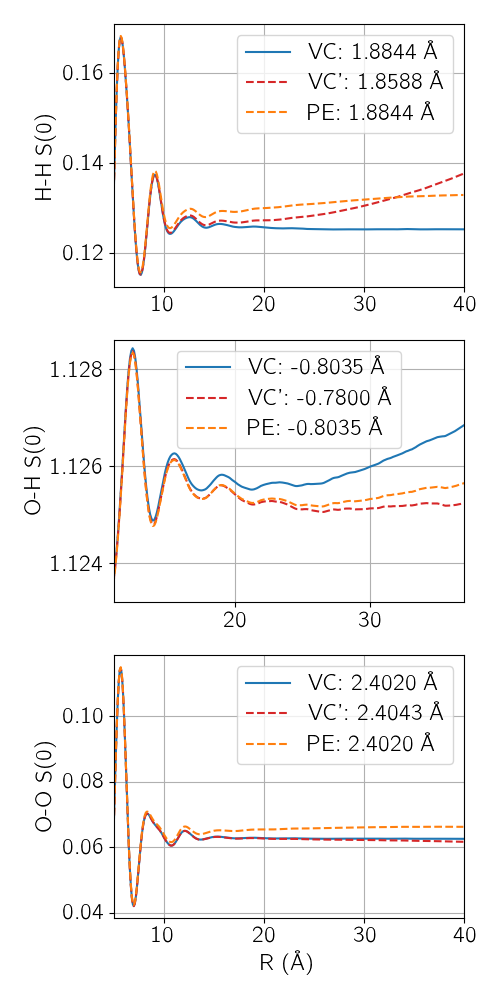

(1.1231840156, 1.128617398521579)

In [36]:
hand_tuned = [1.8587507070017437, 0.22004936062999395,  0.2199342798093289,  2.404314988289669]
hand_tuned = [1.8587507070017437, -.78,  -.78,  2.404314988289669]

V = rdfset[('H', 'solvent', 'O', 'solvent')].volume  # just get it from somewhere.
sgr = SGr2(V, qvec=np.arange(0, 0.001, 0.001))

fig, axes = plt.subplots(3, 1, figsize=(5, 10))
ct = 0
s_vc = np.zeros((4, len(rmaxs)))
s_pe = np.zeros((4, len(rmaxs)))
s_hc = np.zeros((4, len(rmaxs)))
for i, (key, org_rdf) in enumerate(rdfset.items()):
    if key == ('H', 'solvent', 'O', 'solvent'):  # skip the double. OH = HO
        continue
    for j, r_max in enumerate(rmaxs):
        damp = Damping('simple', L=r_max)
        
        rdf_vc = deepcopy(org_rdf)
        rdf_hc = deepcopy(org_rdf)
        rdf_pe = deepcopy(org_rdf)
        
        # VC Correct
        dvo = DVOpt(deepcopy(org_rdf), fit_strt=25, fit_stop=40, rmaxes=rmaxs)
        rdf_vc.g = dvo.volume_correct(opts[i])
        rdf_vc.damp = damp
        rdf_vc.r_max = r_max
        
        # VC Correct - Hand tuned
        dvo = DVOpt(deepcopy(org_rdf), fit_strt=25, fit_stop=40, rmaxes=rmaxs)
        rdf_hc.g = dvo.volume_correct(hand_tuned[i])
        rdf_hc.damp = damp
        rdf_hc.r_max = r_max

        # Perera
        dvo = DVOpt(deepcopy(org_rdf), fit_strt=25, fit_stop=40, rmaxes=rmaxs)
        rdf_pe.g = dvo.perera_correct(opts_pe[i])
        rdf_pe.damp = damp
        rdf_pe.r_max = r_max
        
        s_vc[i, j] = sgr.structure_factor(rdf_vc)
        s_hc[i, j] = sgr.structure_factor(rdf_hc)
        s_pe[i, j] = sgr.structure_factor(rdf_pe)
        
    ax = axes[ct]
    ax.plot(rmaxs, s_vc[i, :], label=f'VC: {opts[i]:6.4f} Å')
    ax.plot(rmaxs, s_hc[i, :], 'C3--', label=f'VC\': {hand_tuned[i]:6.4f} Å')
    ax.plot(rmaxs, s_pe[i, :], '--', label=f'PE: {opts[i]:6.4f} Å')
    ax.set_ylabel(f'{key[0]}-{key[2]} S(0)')
    ax.grid()
    ax.set_xlim([5, 40])
    ax.legend(loc='best')
    ct += 1
    
ax.set_xlabel('R (Å)') 
axes[1].set_xlim(11, 37)
axes[1].set_ylim(1.1231840156, 1.128617398521579)


In [77]:
qvec = np.arange(0, 10, 0.01)
i_rdf_uc = np.zeros(len(qvec))  # uncorrected
i_rdf_vc = np.zeros(len(qvec))  # volume corrected based on mean(RDF) fit
i_rdf_hc = np.zeros(len(qvec))  # Hand-tuned Volume-correction
i_rdf_pe = np.zeros(len(qvec))  # Perera corrected, based on mean(RDF) fit

i_lin_pe = np.zeros(len(qvec))  # Perera corrected, based on the linearity-fit
i_lin_vc = np.zeros(len(qvec))  # Volume corrected, based on the linearity-fit

i_bad_fade = np.zeros(len(qvec))  # Versions where we just abuse the window function
i_bad_lorch = np.zeros(len(qvec))  

sgr = SGr2(V, qvec=qvec)

for i, (key, uc_rdf) in enumerate(rdfset.items()):
    vc_rdf = vc_rdfset[key]
    
    hc_rdf = deepcopy(uc_rdf)   
    hc_rdf.g = DVOpt(hc_rdf).volume_correct(hand_tuned[i])
    
    pe_rdf = deepcopy(uc_rdf)   
    pe_rdf.g = DVOpt(pe_rdf).perera_correct(opts_pe[i])
    
    linpe_rdf = deepcopy(uc_rdf)   
    linpe_rdf.g = DVOpt(linpe_rdf).perera_correct(pe_best_values[i])

    linvc_rdf = deepcopy(uc_rdf)   
    linvc_rdf.g = DVOpt(linvc_rdf).volume_correct(vc_best_values[i])
    
    bd_rdf = deepcopy(uc_rdf)
    bd_rdf_lorch = deepcopy(uc_rdf)
    
    vc_rdf.damp = Damping('simple', L=vc_rdf.r[-1])
    uc_rdf.damp = Damping('simple', L=uc_rdf.r[-1])
    hc_rdf.damp = Damping('simple', L=hc_rdf.r[-1])
    pe_rdf.damp = Damping('simple', L=pe_rdf.r[-1])
    
    linpe_rdf.damp = Damping('simple', L=linpe_rdf.r[-1])
    linvc_rdf.damp = Damping('simple', L=linvc_rdf.r[-1])
    
    bd_rdf.damp = Damping('panman', L=6)
    bd_rdf_lorch.damp = Damping('simple', L=12)

    
    i_rdf_uc += sgr.scoh(uc_rdf)
    i_rdf_vc += sgr.scoh(vc_rdf)
    i_rdf_hc += sgr.scoh(hc_rdf)
    i_rdf_pe += sgr.scoh(pe_rdf)
    
    i_lin_vc += sgr.scoh(linvc_rdf)
    i_lin_pe += sgr.scoh(linpe_rdf)
    
    i_bad_fade += sgr.scoh(bd_rdf)
    i_bad_lorch += sgr.scoh(bd_rdf_lorch)
    

<IPython.core.display.Javascript object>


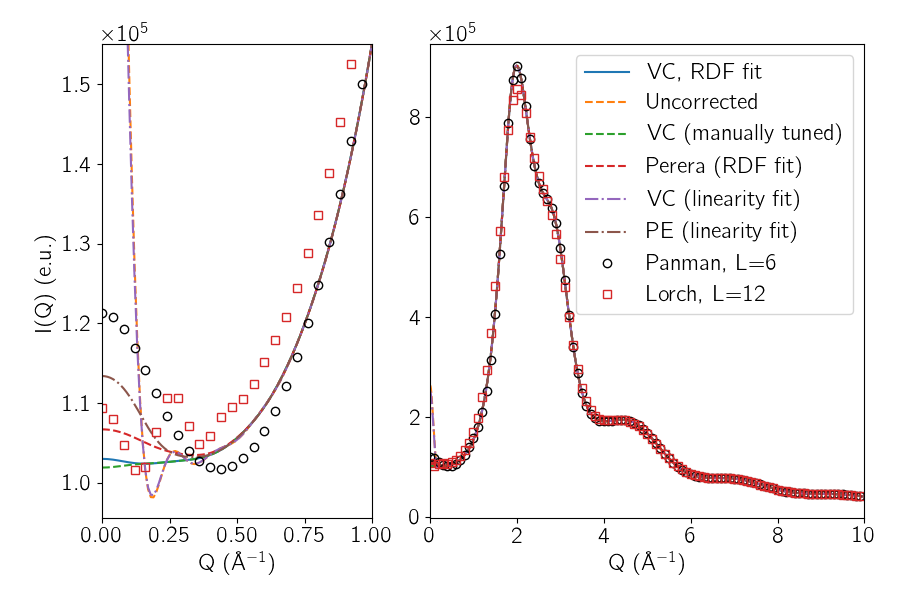

In [82]:
fig = plt.figure(figsize=(9, 6))
gs1 = fig.add_gridspec(nrows=1, ncols=5)
ax1 = fig.add_subplot(gs1[0, :2])
ax2 = fig.add_subplot(gs1[0, 2:])
axes = [ax1, ax2]

ax = ax1
ax.plot(qvec, i_rdf_vc)
ax.plot(qvec, i_rdf_uc, '--')
ax.plot(qvec, i_rdf_hc, '--')
ax.plot(qvec, i_rdf_pe, '--')
ax.plot(qvec, i_lin_vc, linestyle='dashdot')
ax.plot(qvec, i_lin_pe, linestyle='dashdot')

ax.plot(qvec[::4], i_bad_fade[::4], 'ko', mfc='None')
ax.plot(qvec[::4], i_bad_lorch[::4], 'C3s', mfc='None', label='Loch, L=12')

ax.set_ylabel('I(Q) (e.u.)')

ax.set_xlim([0, 1])
ax.set_ylim([9.56e4, 1.55e5])

ax = ax2
ax.plot(qvec, i_rdf_vc, label='VC, RDF fit')
ax.plot(qvec, i_rdf_uc, '--', label='Uncorrected')
ax.plot(qvec, i_rdf_hc, '--', label='VC (manually tuned)')
ax.plot(qvec, i_rdf_pe, '--', label='Perera (RDF fit)')
ax.plot(qvec, i_lin_vc, linestyle='dashdot', label='VC (linearity fit)')
ax.plot(qvec, i_lin_pe, linestyle='dashdot', label='PE (linearity fit)')
ax.plot(qvec[::10], i_bad_fade[::10], 'ko', mfc='None', label='Panman, L=6')
ax.plot(qvec[::10], i_bad_lorch[::10], 'C3s', mfc='None', label='Lorch, L=12')

ax.set_xlim([0, 10])
ax.legend(loc='best')


for ax in axes:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel('Q (Å$^{-1}$)')
fig.tight_layout()

The truncation artifacts from truncating a non-corrected RDF show up in the total scattering signal from ~0.6 Å$^{-1}$

Simply abusing various window-functions can smoothen out the low-q oscillations: The "Panman" function:
\begin{align}
w(r) = \exp\left( -\frac{r}{L} - 1 \right)^2,
\end{align}
does so convincingly, even for and $L$ value as short as 6 Å. However, discrepancies from the total corrected signal can be seen already around 1 Å$^{-1}$. When the final goal is obtaining robust $\Delta I(Q)$-signals on the order of 1/1000th of amplitude of the total signal, these discrepancies can be detrimental.

Playing around with the $L$ in the Lorch function: 
\begin{align}
w(r) = \frac{\sin (\pi r /  L)}{\pi r /L},
\end{align}
Provides even worse results, the low-q oscillations are still present, while the actual water peak has been affected. 

The Volume-Corrected RDF-scattering, obtained by either manually tuning the radii of the excluded volume, or by fitting the radii to minimize the difference between the asymptotic RDF-value from 1 gives robust, consistent results down to $Q > 0.16$ Å$^{-1}$, which should be enough for even small beamstops. 

Now if we want to go even further, the problem becomes determining which of the $Q > 0.2$ has the correct answer. Here we can either:

1. Go back to the structure factor and use the isothermal compressibility - since we're dealing with neat water.
2. Use a more general method of analysing the effect of truncating the integration at different $R_\mathrm{max}$-values, as a perfectly corrected RDF should produce identical $S(Q \rightarrow 0)$ (and thus also $I(Q \rightarrow 0)$)-values independent of where the integral is cut off (assuming it is cut off after local structure has died out) 